<a id='Top'></a>

# Multisurv model training<a class='tocSkip'></a>

Train MultiSurv models with different combinations of input data modalities.

In [1]:
!pip install tensorboard

In [2]:
%load_ext autoreload
%autoreload 2

%load_ext watermark

import sys
import os

import ipywidgets as widgets
import pandas as pd
import torch

if torch.cuda.is_available():
    print('>>> PyTorch detected CUDA <<<')

# Make modules in "src" dir visible
if os.getcwd() not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'src'))

import utils
from model import Model

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#DataLoader" data-toc-modified-id="DataLoader-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><code>DataLoader</code></a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#Different-intervals" data-toc-modified-id="Different-intervals-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Different intervals</a></span><ul class="toc-item"><li><span><a href="#Equidistant-times" data-toc-modified-id="Equidistant-times-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Equidistant times</a></span></li><li><span><a href="#By-duration-quantiles" data-toc-modified-id="By-duration-quantiles-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>By duration quantiles</a></span></li></ul></li><li><span><a href="#Pick-learning-rate" data-toc-modified-id="Pick-learning-rate-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Pick learning rate</a></span></li><li><span><a href="#Fit" data-toc-modified-id="Fit-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Fit</a></span><ul class="toc-item"><li><span><a href="#Save-model-weights" data-toc-modified-id="Save-model-weights-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Save model weights</a></span></li></ul></li><li><span><a href="#Check-validation-metrics" data-toc-modified-id="Check-validation-metrics-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Check validation metrics</a></span></li></ul></li></ul></div>

In [3]:
DATA = utils.INPUT_DATA_DIR
MODELS = utils.TRAINED_MODEL_DIR

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# `DataLoader`

In [4]:
data_modalities = widgets.SelectMultiple(
    options=['clinical', 'mRNA', 'DNAm', 'miRNA', 'CNV', 'wsi'],
    index=[0, 1],
    rows=6,
    description='Input data',
    disabled=False
)
display(data_modalities)

SelectMultiple(description='Input data', index=(0, 1), options=('clinical', 'mRNA', 'DNAm', 'miRNA', 'CNV', 'w…

In [5]:
#-----------------------------------------------------------------------------#
#                             20-CANCER SUBSET                                #
#                 (to compare to Cheerla and Gevaert 2019)                    #
#-----------------------------------------------------------------------------#

cancers = ['BRCA']

labels = pd.read_csv('/app/data/labels.tsv', sep='\t')
print(labels.head(3))


   submitter_id      time  event  group
0  TCGA-Z7-A8R6  8.920548      0  train
1  TCGA-C8-A1HE  1.027397      0  train
2  TCGA-A8-A07B  3.583562      0  train


In [6]:
dataloaders = utils.get_dataloaders(data_location=DATA,
                                    labels_file='/app/data/labels.tsv',
                                    modalities=data_modalities.value,
                                    wsi_patch_size=299,
                                    n_wsi_patches=5,
#                                     batch_size=20,
#                                    batch_size=64,
                                     batch_size=32,
#                                     exclude_patients=exclude_cancers,
                                   )

Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 876
   val: 110
   test: 108

Batch size: 32


# Model

## Different intervals

If trying out different time interval outputs.

### Equidistant times

In [7]:
interval_cuts = torch.arange(0., 365 * 5.1, 365 / 2)

### By duration quantiles

In [8]:
labels = [(t, e) for t, e in dataloaders['train'].dataset.label_map.values()]
durations = [t for t, _ in labels]
events = [e for _, e in labels]

interval_cuts = utils.discretize_time_by_duration_quantiles(durations, events, 20)
interval_cuts = torch.from_numpy(interval_cuts)

In [9]:
cosine_embedding_margin = 1e-5
auxiliary_criterion = torch.nn.CosineEmbeddingLoss(margin=cosine_embedding_margin)

multisurv = Model(
    dataloaders=dataloaders,
    auxiliary_criterion=auxiliary_criterion,
    output_intervals=interval_cuts,
    device=device
)

Instantiating MultiSurv model...


In [10]:
print('Output intervals (in years):')
multisurv.output_intervals / 365

Output intervals (in years):


tensor([ 0.0000,  1.5562,  2.4137,  3.0712,  4.0082,  4.6356,  5.2767,  6.4329,
         6.8904,  7.5589,  8.0904,  8.9342,  9.4685,  9.8822, 10.4301, 10.7562,
        11.9479, 19.5233, 23.5753], dtype=torch.float64)

In [11]:
multisurv.model_blocks

['clinical_submodel', 'mRNA_submodel', 'aggregator', 'fc_block', 'risk_layer']

In [12]:
print('Trainable blocks:')
layer = None

for name, child in multisurv.model.named_children():
    for name_2, params in child.named_parameters():
        if name is not layer:
            print(f'   {name}: {params.requires_grad}')
        layer = name

Trainable blocks:
   clinical_submodel: True
   mRNA_submodel: True
   fc_block: True
   risk_layer: True


In [13]:
multisurv.model

MultiSurv(
  (clinical_submodel): ClinicalNet(
    (embedding_layers): ModuleList(
      (0): Embedding(2, 1)
      (1): Embedding(7, 4)
      (2-4): 3 x Embedding(3, 2)
      (5-6): 2 x Embedding(4, 2)
    )
    (embedding_dropout): Dropout(p=0.5, inplace=False)
    (bn_layer): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear): Linear(in_features=16, out_features=256, bias=True)
    (output_layer): FC(
      (fc): Sequential(
        (0): Dropout(p=0.5, inplace=False)
        (1): Linear(in_features=256, out_features=512, bias=True)
        (2): ReLU()
      )
    )
  )
  (mRNA_submodel): FC(
    (fc): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Linear(in_features=1000, out_features=4096, bias=True)
      (2): ReLU()
      (3): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Dropout(p=0.5, inplace=False)
      (5): Linear(in_features=4096, out_features=4096, bias=True)
      (6):

## Pick learning rate

In [14]:
data_example, _, _ = dataloaders['train'].dataset[0]
print("Categorical features:\n", data_example['clinical'][0])
print("Continuous features:\n", data_example['clinical'][1])


Categorical features:
 tensor([0., 6., 0., 1., 0., 0., 0.])
Continuous features:
 tensor([0.6961])


In [15]:
multisurv.model.zero_grad()
for param in multisurv.model.parameters():
    param.grad = None

In [16]:
# Ultimate fix: Replace the entire lr_range_test.py run method

def completely_fixed_lr_test_run(self, init_value=1e-8, final_value=10., beta=0.98):
    """Completely rewritten LR test that avoids the inplace operation issue."""
    print(">>> Using COMPLETELY FIXED lr_test.run method")
    
    power = (1 / (len(self.dataloader) - 1))
    mult = (final_value / init_value) ** power
    lr = init_value
    self.optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0

    print('>>> Compute loss at increasing LR values')
    
    # Clear losses and lrs lists
    self.losses = []
    self.lrs = []

    for data in self.dataloader:
        batch_num += 1
        print('\r' + f'    Iterate over mini-batches: {str(batch_num)}', end='')

        try:
            # COMPLETELY MANUAL APPROACH - avoid ModelCoach entirely
            
            # Unpack data
            if len(data) == 3:
                modality_data, time, event = data
            elif len(data) == 4:
                modality_data, time, event, pid = data
            
            # Move to device manually
            for key, value in modality_data.items():
                if isinstance(value, torch.Tensor):
                    modality_data[key] = value.to(self.device)
                elif isinstance(value, (list, tuple)):
                    modality_data[key] = tuple(v.to(self.device) if isinstance(v, torch.Tensor) else v for v in value)
            
            time = time.to(self.device)
            event = event.to(self.device)
            
            # Set model to train mode
            self.model.train()
            
            # Clear gradients
            self.optimizer.zero_grad()
            
            # Forward pass
            with torch.set_grad_enabled(True):
                feature_representations, risk = self.model(modality_data)
                modality_features = feature_representations['modalities']
                
                # Compute loss manually (fix the arguments)
                try:
                    # The loss function signature is: forward(risk, times, events, breaks, device)
                    # NOT forward(risk, times, events, modality_features, breaks)
                    breaks = self.output_intervals
                    if isinstance(breaks, (list, tuple)):
                        breaks = torch.tensor(breaks, dtype=torch.float32, device=self.device)
                    
                    loss = self.criterion(risk, times=time, events=event, breaks=breaks, device=self.device)
                        
                except Exception as loss_error:
                    print(f"\nPrimary criterion failed: {loss_error}")
                    # Fallback to simple MSE loss for LR range test
                    dummy_target = torch.ones_like(risk)
                    loss = torch.nn.functional.mse_loss(risk, dummy_target)
                    print("Using fallback MSE loss")
                
                # Add auxiliary loss if needed (fix the argument mismatch)
                if self.aux_criterion is not None:
                    try:
                        # CosineEmbeddingLoss expects (input1, input2, target)
                        # Let's use the two modality features
                        if len(modality_features) >= 2:
                            # Create a dummy target (1 for similar, -1 for dissimilar)
                            target = torch.ones(modality_features[0].shape[0], device=self.device)
                            aux_loss = self.aux_criterion(modality_features[0], modality_features[1], target)
                            loss = loss + 0.1 * aux_loss  # Scale down aux loss
                        else:
                            print("Skipping aux loss - insufficient modality features")
                    except Exception as aux_error:
                        print(f"\nAuxiliary criterion failed: {aux_error}")
                        print("Skipping auxiliary loss")
            
            # Store the loss value
            loss_value = loss.item()
            
        except Exception as e:
            print(f"\nError at batch {batch_num}: {e}")
            break

        # Compute the smoothed loss
        avg_loss = (beta * avg_loss + (1 - beta) * loss_value)
        smoothed_loss = avg_loss / (1 - beta ** batch_num)

        # Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            print()
            print('    Exploding loss; finish test.')
            break

        # Record the best loss
        if smoothed_loss < best_loss or batch_num == 1:
            best_loss = smoothed_loss
            
        # Store the values
        self.losses.append(smoothed_loss)
        self.lrs.append(lr)

        # Do the backward pass and optimizer step
        try:
            # CRITICAL: Use retain_graph=False and no double backward pass
            loss.backward(retain_graph=False)
            self.optimizer.step()
        except Exception as e:
            print(f"\nBackward pass failed at batch {batch_num}: {e}")
            break

        # Update the lr for the next step
        lr *= mult
        self.optimizer.param_groups[0]['lr'] = lr
        
        # Stop after reasonable number of batches to avoid infinite loops
        if batch_num >= 100:
            print("\nStopping after 100 batches")
            break

    print()
    print('    Completed test.')
    return self

# Apply the complete fix
import lr_range_test
lr_range_test.LRRangeTest.run = completely_fixed_lr_test_run
print("Applied COMPLETE fix to LRRangeTest.run")

Applied COMPLETE fix to LRRangeTest.run


In [17]:
%%time

torch.autograd.set_detect_anomaly(False)  # Disable anomaly detection too
multisurv.test_lr_range()

>>> Using COMPLETELY FIXED lr_test.run method
>>> Compute loss at increasing LR values
    Iterate over mini-batches: 27
    Completed test.
CPU times: user 26.7 s, sys: 4.81 s, total: 31.5 s
Wall time: 3.71 s


Number of loss values collected: 27
Number of learning rates tested: 27
LR range: 1.00e-06 to 1.00e+01
Loss range: 0.112443 to 0.149201


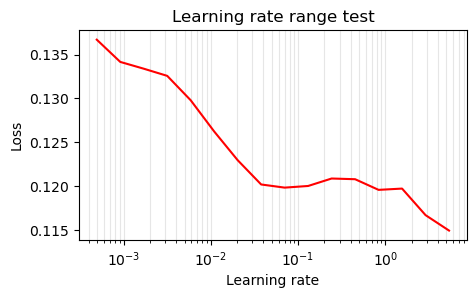

In [20]:
# Check the results
print(f"Number of loss values collected: {len(multisurv.lr_test.losses)}")
print(f"Number of learning rates tested: {len(multisurv.lr_test.lrs)}")
print(f"LR range: {min(multisurv.lr_test.lrs):.2e} to {max(multisurv.lr_test.lrs):.2e}")
print(f"Loss range: {min(multisurv.lr_test.losses):.6f} to {max(multisurv.lr_test.losses):.6f}")

# Plot the results to find optimal learning rate
multisurv.plot_lr_range(trim=1)

## Fit

In [30]:
# Fix for the _predictions_to_pycox method in coach.py

def fixed_predictions_to_pycox(self, preds, time_points=None):
    """Fixed version that properly handles the DataFrame structure."""
    import pandas as pd
    import torch
    
    # preds shape is [num_patients, num_intervals] e.g., [864, 18]
    # Convert predictions to DataFrame
    df = pd.DataFrame(preds.cpu().numpy())
    
    if time_points is None:
        # Get the number of intervals from the model output
        n_intervals = preds.shape[1]  # Should be 18 for your model
        
        # Use the model's actual output intervals
        if hasattr(self, 'output_intervals') and self.output_intervals is not None:
            # Use the midpoints of the output intervals
            intervals = self.output_intervals
            if len(intervals) > n_intervals:
                # Take the first n_intervals midpoints
                midpoints = (intervals[:-1] + intervals[1:]) / 2
                time_points = midpoints[:n_intervals]
            else:
                # Fallback to evenly spaced points
                time_points = torch.linspace(0.5, intervals[-1].item() / 365, n_intervals)
        else:
            # Fallback: create time points that match the output size
            time_points = torch.arange(0.5, 0.5 + n_intervals, 1.0)
    
    # Ensure time_points matches the prediction dimensions
    if len(time_points) != preds.shape[1]:
        print(f"Warning: Adjusting time_points from {len(time_points)} to {preds.shape[1]}")
        time_points = torch.linspace(time_points[0], time_points[-1], preds.shape[1])
    
    # FIXED: The DataFrame structure should be transposed
    # We want columns to be time points, rows to be patients
    df = df.T  # Transpose so shape becomes [num_intervals, num_patients]
    
    # Convert time_points to numpy if it's a tensor
    if torch.is_tensor(time_points):
        time_points = time_points.cpu().numpy()
    
    # Set the index to time points
    df.index = time_points
    df.index.name = 'time'
    
    return df

# Apply the fix to ModelCoach
from coach import ModelCoach
ModelCoach._predictions_to_pycox = fixed_predictions_to_pycox
print("Applied corrected fix to ModelCoach._predictions_to_pycox method")

# Debug info
print(f"Model output intervals shape: {len(multisurv.output_intervals)}")
print(f"Model risk layer output: {multisurv.model.risk_layer[0].out_features}")
print(f"Expected: {len(multisurv.output_intervals) - 1} intervals for {len(multisurv.output_intervals)} breakpoints")

Applied corrected fix to ModelCoach._predictions_to_pycox method
Model output intervals shape: 19
Model risk layer output: 18
Expected: 18 intervals for 19 breakpoints


In [26]:
import os
import time
import utils
from datetime import datetime

# 1. Record start time
start_time = time.time()

# 2. Set up training parameters
picked_lr = 5e-3

# Add timestamp to make unique run tags
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

run_tag = utils.compose_run_tag(
    model=multisurv, 
    lr=picked_lr,
    dataloaders=multisurv.dataloaders,
    log_dir='./training_logs/',
    suffix=f'_breast_cancer_{timestamp}'  # Add timestamp
)

# 3. Create log directory (now it will be unique)
log_dir = os.path.join('./training_logs/', run_tag)
os.makedirs(log_dir, exist_ok=True)
print(f"Log directory created: {log_dir}")

Run tag: "clinical_mRNA_lr0.005_breast_cancer_20250617_174106"
Log directory created: ./training_logs/clinical_mRNA_lr0.005_breast_cancer_20250617_174106


In [ ]:
fit_args = {
    'lr': picked_lr,
    'num_epochs': 75,
    'info_freq': 5,
    'lr_factor': 0.5,
    'scheduler_patience': 10,
    'log_dir': log_dir,  # Use the verified directory
}

print(f"Starting training with LR: {picked_lr}")

# 4. Train the model
multisurv.fit(**fit_args)

# 5. Calculate and display elapsed time
hrs, mins, secs = utils.elapsed_time(start_time)
print(f"Training completed in {hrs}h {mins}m {secs}s")

Starting training with LR: 0.005
Instantiating MultiSurv model...

------------------------------------------
             Training        Validation
           ------------     ------------
 Epoch     Loss     Ctd     Loss     Ctd
------------------------------------------
 1/75     0.7148   0.478   0.7289   0.493


### Save model weights

If desired.

In [ ]:
multisurv.best_model_weights.keys()

In [ ]:
multisurv.best_concord_values

In [ ]:
multisurv.current_concord

In [ ]:
multisurv.save_weights(saved_epoch='epoch39', prefix=run_tag, weight_dir=MODELS)

## Check validation metrics

In [ ]:
dataloaders = utils.get_dataloaders(data_location=DATA,
                                    labels_file='data/labels.tsv',
                                    modalities=data_modalities.value,
                                    wsi_patch_size=299,
                                    n_wsi_patches=5,
#                                     exclude_patients=exclude_cancers,
                                    return_patient_id=True,
                                   )

In [ ]:
performance = utils.Evaluation(
    model=multisurv, dataset=dataloaders['val'].dataset,
    device=device)
performance.compute_metrics()
performance.show_results()

# Watermark <a class='tocSkip'></a>

In [ ]:
%watermark --iversions
%watermark -v
print()
%watermark -u -n

[Top of the page](#Top)